In [165]:
import requests
import json

from census import Census
from us import states

from config import apikey
from config import gkey

import gmaps
gmaps.configure(api_key=gkey)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [138]:
#API calls census using wrapper
c = Census(apikey, year=2017)
census_data = c.acs5.get(("B01003_001E","B01002_001E"),{'for': 'county:*', 'in': 'state:*' })

#converting to dataFrame
census_pd = pd.DataFrame(census_data)

#Renaming the columns
census_pd=census_pd.rename(columns={"B01003_001E":"Total Population","B01002_001E":"Median Age","state":"fips"})

#extracting state population from census data

Population=census_pd.groupby('fips')['Total Population'].sum()
final_fips=census_pd.groupby('fips')['fips'].first()

state_population=pd.DataFrame({"Total Population":Population,"State Fips":final_fips})
state_population.loc[:,'State Fips']=state_population["State Fips"].astype('int64')

In [139]:
zip_path="state_fips_master.csv"
zip_df=pd.read_csv(zip_path)
zip_df=zip_df.rename(columns={"fips":"State Fips"})

#Merging the census_pd with state_zip_df to obtain state_name column in Census dataFrame
Census_df=pd.merge(state_population,zip_df,on="State Fips")
Census_df=Census_df.rename(columns={"State Fips":"fips","state_name":"State Name"})
Census_df.head()

,Total Population,fips,State Name,state_abbr,long_name,sumlev,region,division,state,region_name,division_name
0,4850771.0,1,Alabama,AL,Alabama AL,40,3,6,1,South,East South Central
1,738565.0,2,Alaska,AK,Alaska AK,40,4,9,2,West,Pacific
2,6809946.0,4,Arizona,AZ,Arizona AZ,40,4,8,4,West,Mountain
3,2977944.0,5,Arkansas,AR,Arkansas AR,40,3,7,5,South,West South Central
4,38982847.0,6,California,CA,California CA,40,4,9,6,West,Pacific


In [162]:
csv_path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

# Read the CSV into a Pandas DataFrame
covid_df = pd.read_csv(csv_path)

In [8]:
#Covid-19 Data on County level

#extracting latest information from the live data
cases_covid=covid_df.groupby(['fips','county','state'])['cases'].last()
deaths_covid=covid_df.groupby(['fips','county','state'])['deaths'].last()
date_covid=covid_df.groupby(['fips','county','state'])['date'].last()
fips_covid=covid_df.groupby(['fips','county','state'])['fips'].first()
state_covid=covid_df.groupby(['fips','county','state'])['state'].first()
county_covid=covid_df.groupby(['fips','county','state'])['county'].first()

#creating new dataframe
County_Covid_df=pd.DataFrame({"Date":date_covid,
                             "County":county_covid,
                             "Total Number of Covid-19 Cases":cases_covid,
                             "Death due to Covid-19":deaths_covid})

,,,Date,County,Total Number of Covid-19 Cases,Death due to Covid-19
fips,county,state,,,,
1001.0,Autauga,Alabama,2020-04-14,Autauga,23,1
1003.0,Baldwin,Alabama,2020-04-14,Baldwin,87,2
1005.0,Barbour,Alabama,2020-04-14,Barbour,11,0
1007.0,Bibb,Alabama,2020-04-14,Bibb,17,0
1009.0,Blount,Alabama,2020-04-14,Blount,16,0


In [193]:
state_path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
state_df=pd.read_csv(state_path)
state_df=state_df.rename(columns={'date':'Date','state':'State Name','cases':'Total Covid-19 Cases','deaths':'Total Deaths Covid-19'})
state_df.head()

,Date,State Name,fips,Total Covid-19 Cases,Total Deaths Covid-19
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [174]:
#Covid-19 Data on State Level

cases_state=state_df.groupby(['State Name'])['Total Covid-19 Cases'].sum()
deaths_state=state_df.groupby(['State Name'])['Total Deaths Covid-19'].sum()
date_state=state_df.groupby(['State Name'])['date'].last()

State_Covid_df=pd.DataFrame({"Date":date_state,"Total Covid-19 Cases":cases_state,"Total Deaths Covid-19":deaths_state})
State_Covid_df=State_Covid_df.reset_index()
State_Covid_df.head()

,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19
0,Alabama,2020-04-14,40665,974
1,Alaska,2020-04-14,3833,68
2,American Samoa,2020-04-14,0,0
3,Arizona,2020-04-14,44270,1232
4,Arkansas,2020-04-14,18440,311


In [175]:
#Merging 'Total population per state' with 'covid parameters on state level'
complete_df=pd.merge(State_Covid_df,Census_df,on='State Name')
complete_df=complete_df[["Date","State Name","Total Covid-19 Cases","Total Deaths Covid-19","Total Population","fips"]]

In [179]:
#Adding Latitude and Longitude for HeatMap
latlng_path="statelatlong.csv"
latlng_df=pd.read_csv(latlng_path)
latlng_df=latlng_df.rename(columns={"City":"State Name"})
HeatMap_df=pd.merge(latlng_df,complete_df,on="State Name")

In [180]:
#Calculating state mortality rates

mortality_df=(HeatMap_df['Total Deaths Covid-19']/HeatMap_df['Total Population'])*100000
HeatMap_df['Mortality per 100,000']=mortality_df
HeatMap_df.head()

,State,Latitude,Longitude,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19,Total Population,fips,"Mortality per 100,000"
0,AL,32.601011,-86.680736,Alabama,2020-04-14,40665,974,4850771.0,1,20.079282
1,AK,61.302501,-158.775020,Alaska,2020-04-14,3833,68,738565.0,2,9.207043
2,AZ,34.168219,-111.930907,Arizona,2020-04-14,44270,1232,6809946.0,4,18.091186
3,AR,34.751928,-92.131378,Arkansas,2020-04-14,18440,311,2977944.0,5,10.443447
4,CA,37.271875,-119.270415,California,2020-04-14,308354,7809,38982847.0,6,20.031887


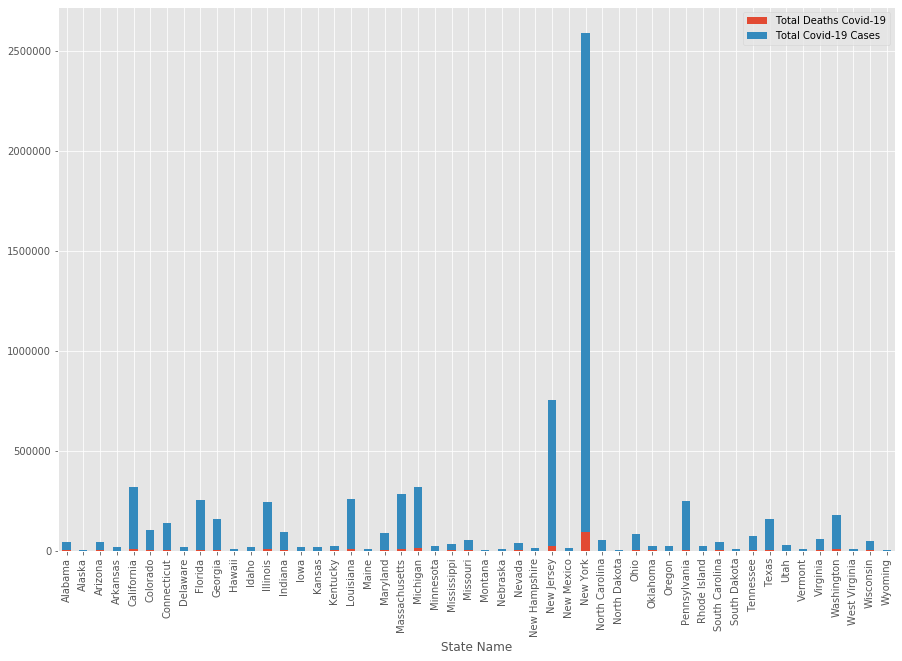

In [177]:
#StackedBar for Total Cases and Total Deaths

pivot_df=HeatMap_df[['State Name','Total Deaths Covid-19','Total Covid-19 Cases']]
pivot_df=pivot_df.set_index('State Name')

stack_fig= pivot_df[['Total Deaths Covid-19','Total Covid-19 Cases']].plot(kind="bar",figsize=(15,10), stacked=True)

In [181]:
#Covid 'Mortality per 100,000' per state in the USA

locations = HeatMap_df[["Latitude", "Longitude"]]

# Plot Heatmap
Covid = gmaps.figure()

impact=HeatMap_df['Mortality per 100,000']

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=impact, dissipating=False, max_intensity=10,point_radius=1)

# Add layer
Covid.add_layer(heat_layer)

# Display figure
Covid

Figure(layout=FigureLayout(height='420px'))

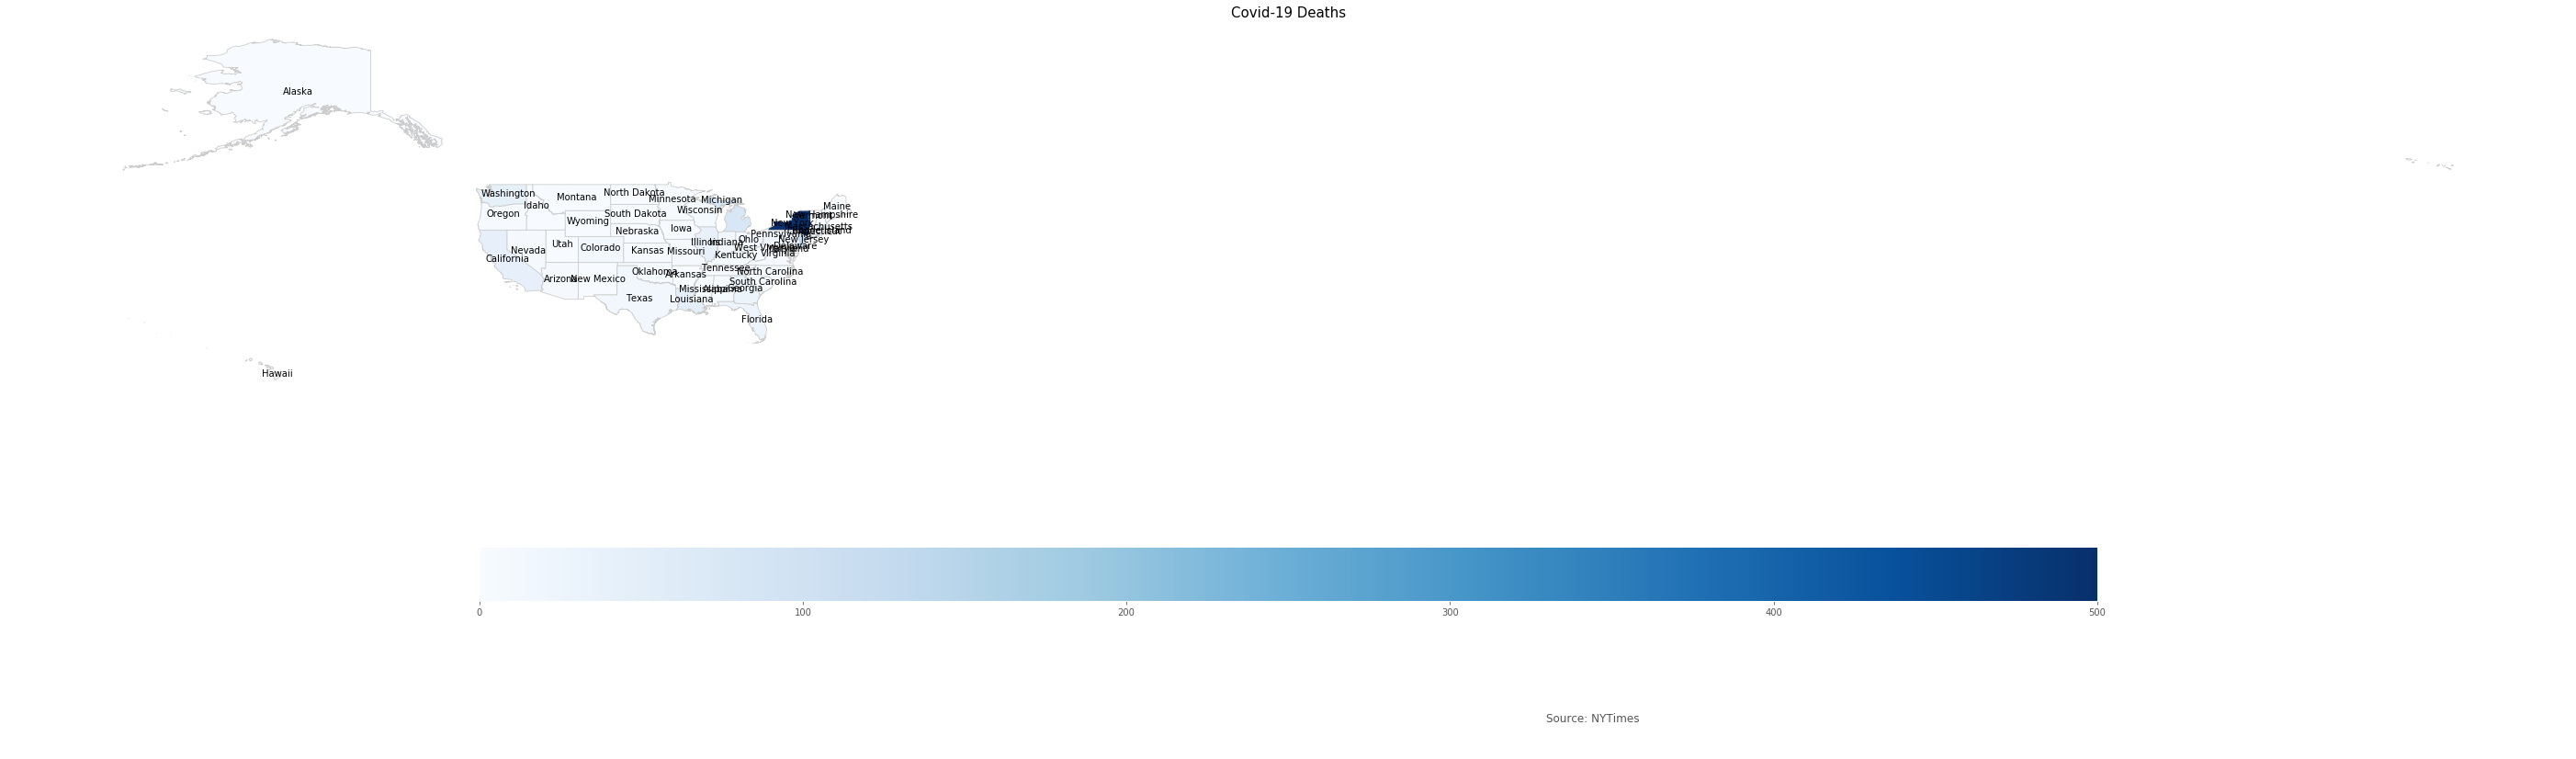

In [202]:
import geopandas as gpd
shapefile='data/cb_2018_us_state_500k.shp'
gdf = gpd.read_file(shapefile)[['NAME','geometry']]
gdf.columns=['State Name','geometry']

#Merging geodataframe and dataframe 
Covid_Visual = gdf.merge(HeatMap_df, left_on = 'State Name', right_on = 'State Name')

#value to be visualised
variable='Total Deaths Covid-19'

# set the range for the choropleth values
vmin, vmax = 0, 500

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(50, 30))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title('Covid-19 Deaths', fontdict={'fontsize': '20'})
ax.annotate('Source: NYTimes', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) 

# create map
Covid_Visual.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
Covid_Visual['coords'] = Covid_Visual['geometry'].apply(lambda x: x.representative_point().coords[:])
Covid_Visual['coords'] = [coords[0] for coords in Covid_Visual['coords']]

for idx, row in Covid_Visual.iterrows():
    plt.annotate(s=row['State Name'], xy=row['coords'],horizontalalignment='center')
            
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)

fig.savefig('covid.png', dpi=300)

# Dataset name: COVID-19 Hospital Needs and Death Projections
Source=http://www.healthdata.org/covid/data-downloads

*allbed_mean= Mean covid beds needed by day
*ICUbed_mean= Mean ICU covid beds needed by day
*InvVen_mean= Mean invasive ventilation needed by day
*deaths_mean= Mean daily covid deaths
*admis_mean= Mean hospital admissions by day
*newICU_mean= Mean number of new people going to the ICU by day
*totdea_mean= Mean cumulative covid deaths
*bedover_mean= covid all beds needed-(total bed capacity-average all bed usage)
*icuover_mean= covid ICU beds needed-(total ICU capacity-average ICU bed usage)

In [128]:
hospital_csv='Hospitalization_all_locs.csv'
hospital_df=pd.read_csv(hospital_csv)
hospital_df=hospital_df[['location_name','date','allbed_mean',
                         'ICUbed_mean','InvVen_mean',
                         'deaths_mean','admis_mean',
                         'newICU_mean','totdea_mean','bedover_mean',
                         'icuover_mean']]

hospital_df=hospital_df.rename(columns={'location_name':'State Name',"allbed_mean":'Covid beds',
                               'ICUbed_mean':'ICU_covid beds',"InvVen_mean":'Ventilators',
                                "deaths_mean":'Covid Deaths',"admis_mean":'Hospital Admits',
                                'newICU_mean':'New ICU Admits','totdea_mean':'Total Covid Deaths'})

In [204]:
hospital_df

,State Name,date,Covid beds,ICU_covid beds,Ventilators,Covid Deaths,Hospital Admits,New ICU Admits,Total Covid Deaths,bedover_mean,icuover_mean
0,Wyoming,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,Wyoming,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,Wyoming,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,Wyoming,2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,Wyoming,2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
30310,Abruzzo,2020-07-31,0.0,0.0,0.0,0.0,0.0,0.0,201.85,0.0,0.0
30311,Abruzzo,2020-08-01,0.0,0.0,0.0,0.0,0.0,0.0,201.85,0.0,0.0
30312,Abruzzo,2020-08-02,0.0,0.0,0.0,0.0,0.0,0.0,201.85,0.0,0.0
30313,Abruzzo,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,201.85,0.0,0.0


In [129]:
Date = hospital_df.groupby('State Name')['date'].last()
Covid_beds = hospital_df.groupby('State Name')['Covid beds'].last()
ICU_Covid_beds = hospital_df.groupby('State Name')['ICU_covid beds'].last()
Ventilators = hospital_df.groupby('State Name')['Ventilators'].last()
covid_deaths = hospital_df.groupby('State Name')['Covid Deaths'].last()
admits = hospital_df.groupby('State Name')['Hospital Admits'].last()
ICU_new = hospital_df.groupby('State Name')['New ICU Admits'].last()
total_covid_deaths = hospital_df.groupby('State Name')['Total Covid Deaths'].sum()
bedover = hospital_df.groupby('State Name')['bedover_mean'].last()
icuover = hospital_df.groupby('State Name')['icuover_mean'].last()

Hosp_df=pd.DataFrame({'Date':Date,"Covid beds":Covid_beds,"ICU_Covid beds":ICU_Covid_beds,
                           "Ventilators":Ventilators,"Covid Deaths":covid_deaths,
                            "Hospital Admits":admits,'New ICU Admits':ICU_new,
                            "Total Covid Deaths":total_covid_deaths,
                            "BedOver":bedover,"ICUover":icuover
                          })

Hosp_df=Hosp_df.reset_index()
Readiness_df=pd.merge(Hosp_df,Census_df,on='State Name')
Readiness_df

,State Name,Date,Covid beds,ICU_Covid beds,Ventilators,Covid Deaths,Hospital Admits,New ICU Admits,Total Covid Deaths,BedOver,...,Total Population,fips,state_abbr,long_name,sumlev,region,division,state,region_name,division_name
0,Alabama,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,46148.454,0.0,...,4850771.0,1,AL,Alabama AL,40,3,6,1,South,East South Central
1,Alaska,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,4295.225,0.0,...,738565.0,2,AK,Alaska AK,40,4,9,2,West,Pacific
2,Arizona,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,96532.053,0.0,...,6809946.0,4,AZ,Arizona AZ,40,4,8,4,West,Mountain
3,Arkansas,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,19479.187,0.0,...,2977944.0,5,AR,Arkansas AR,40,3,7,5,South,West South Central
4,California,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,183789.236,0.0,...,38982847.0,6,CA,California CA,40,4,9,6,West,Pacific
5,Colorado,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,61787.427,0.0,...,5436519.0,8,CO,Colorado CO,40,4,8,8,West,Mountain
6,Connecticut,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,463975.401,0.0,...,3594478.0,9,CT,Connecticut CT,40,1,1,9,Northeast,New England
7,Delaware,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,5071.974,0.0,...,943732.0,10,DE,Delaware DE,40,3,5,10,South,South Atlantic
8,Florida,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,397486.370,0.0,...,20278447.0,12,FL,Florida FL,40,3,5,12,South,South Atlantic
9,Georgia,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,353381.444,0.0,...,10201635.0,13,GA,Georgia GA,40,3,5,13,South,South Atlantic
